## DeepKriging + PS on Durham data

Let's test our DeepKriging model (which adjusts for preferential sampling via MSE+BCE loss function) on the Durham data.

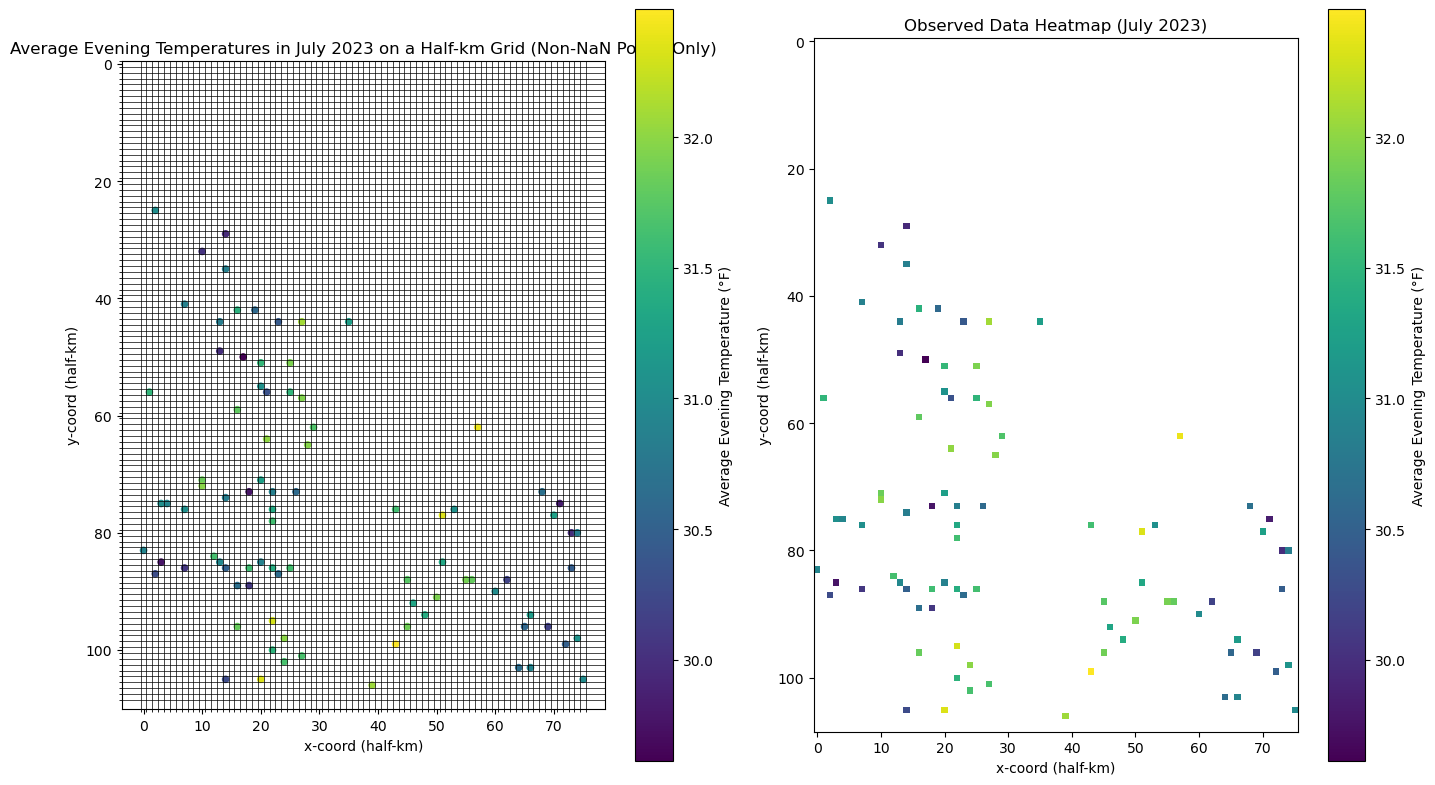

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = np.load('july2023_eve.npy')

# Create a figure with two horizontal subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# 1) Plot only the non-NaN data points on the first subplot
y_coords, x_coords, values = [], [], []
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        if not np.isnan(data[y, x]):
            x_coords.append(x)
            y_coords.append(y)
            values.append(data[y, x])

# Convert to numpy arrays
x_coords = np.array(x_coords)
y_coords = np.array(y_coords)
values = np.array(values)

# Plot the non-NaN points with a scatter plot on the first subplot
sc = axes[0].scatter(x_coords, y_coords, c=values, cmap='viridis', s=20)
fig.colorbar(sc, ax=axes[0], label="Average Evening Temperature (°F)")

# Set grid lines to match the 109 x 76 grid structure on the first subplot
axes[0].set_xticks(np.arange(-0.5, data.shape[1], 1), minor=True)
axes[0].set_yticks(np.arange(-0.5, data.shape[0], 1), minor=True)
axes[0].grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Set aspect to equal for consistent cell dimensions on the first subplot
axes[0].set_aspect('equal')

# Invert the y-axis for the scatter plot to match the imshow orientation
axes[0].invert_yaxis()

# Label axes and title for the first subplot
axes[0].set_title("Average Evening Temperatures in July 2023 on a Half-km Grid (Non-NaN Points Only)")
axes[0].set_xlabel("x-coord (half-km)")
axes[0].set_ylabel("y-coord (half-km)")

# 2) Visualize the observed data (heatmap) on the second subplot
im = axes[1].imshow(data, cmap='viridis', aspect='equal')
fig.colorbar(im, ax=axes[1], label="Average Evening Temperature (°F)")

# Label axes and title for the second subplot
axes[1].set_title("Observed Data Heatmap (July 2023)")
axes[1].set_xlabel("x-coord (half-km)")
axes[1].set_ylabel("y-coord (half-km)")

# Display the plots
plt.tight_layout()  # Adjust spacing between the plots
plt.show()

# note: imshow() displays images with the origin at the top-left corner (by default).








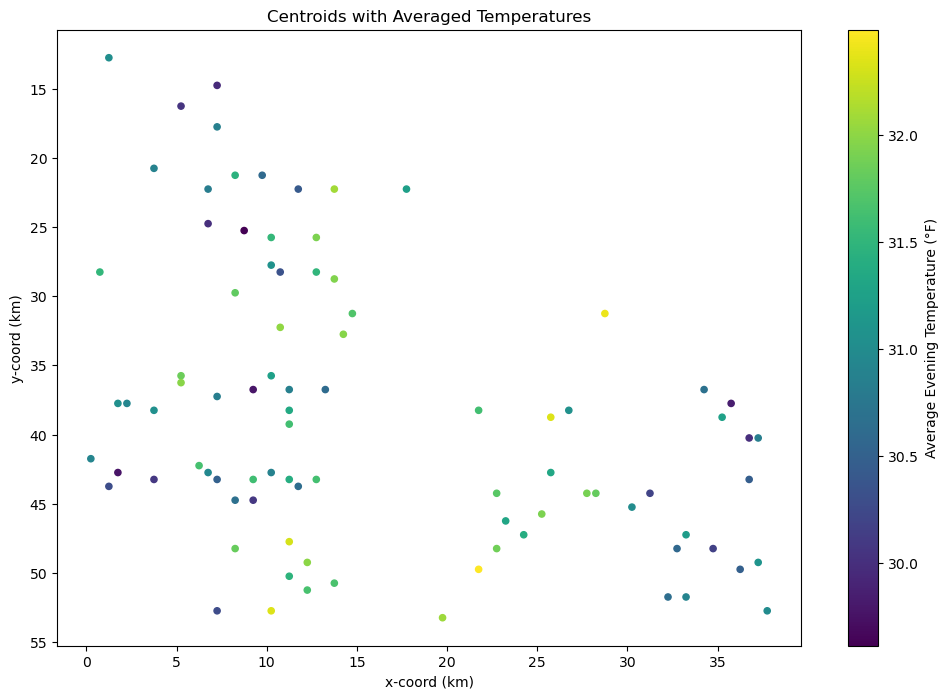

In [2]:
# Okay great, now that we've overlayed the half-km by half-km grid over the data we can
# plot the centroids and start plugging in the centroid data into the model.

# Let's start by plotting the centroids of the 109x76 grid:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from itertools import product

# Define grid dimensions
cells_y, cells_x = data.shape  # cells_y = 109, cells_x = 76
resolution = 0.5  # Each cell represents a 0.5 km x 0.5 km area

# Calculate centroids (one per grid cell)
x_coords = np.arange(cells_x) * resolution + (resolution / 2)
y_coords = np.arange(cells_y) * resolution + (resolution / 2)
centroids = np.array(list(product(y_coords, x_coords)))

# Create a DataFrame with centroid coordinates
df = pd.DataFrame({
    'x': centroids[:, 0],
    'y': centroids[:, 1]
})

flattened_coords = np.array([(y, x) for y in range(cells_y) for x in range(cells_x)])
df['temp_avg'] = [data[y, x] for y, x in flattened_coords]

# Visualize the centroids with their corresponding temperature values
plt.figure(figsize=(12, 8))

# Scatter plot with temperature as color
sc = plt.scatter(df['y'], df['x'], c=df['temp_avg'], cmap='viridis', s=20)
plt.colorbar(sc, label="Average Evening Temperature (°F)")

# Add labels and title
plt.xlabel("x-coord (km)")
plt.ylabel("y-coord (km)")
plt.title("Centroids with Averaged Temperatures")

# Invert the y-axis to match the grid's orientation (top-left origin)
plt.gca().invert_yaxis()

plt.show()



How can I fix the below error?

In [3]:
# print non-nan values and coords from data:

true_observed_coords = []
for y in range(data.shape[0]):
    for x in range(data.shape[1]):
        if not np.isnan(data[y, x]):
            # print(f"y={y}, x={x}, value={data[y, x]}")
            true_observed_coords.append((y, x))
true_observed_coords = sorted(true_observed_coords)

print("true observed coords:")
print(true_observed_coords[:5])

# Separate observed (non-NaN) and unobserved (NaN) points
observed = df[~df['temp_avg'].isna()]
unobserved = df[df['temp_avg'].isna()]
observed_coords = observed[['x', 'y']].to_numpy() # these observed points give the centroid coords of the grid cells that have temperature data

# Compute grid cell indices (row, col) for observed points
observed['grid_row'] = (observed['y'] // resolution).astype(int)
observed['grid_col'] = (observed['x'] // resolution).astype(int)
observed_grid_cell_indices = list(zip(observed['grid_col'], observed['grid_row']))
observed_grid_cell_indices = sorted(observed_grid_cell_indices)

print("observed grid cell indices:")
print(observed_grid_cell_indices[:5])

# FIX BELOW SECTION:

all_grid_cell_indices = set(product(range(cells_y), range(cells_x)))
observed_grid_cell_indices_set = set(observed_grid_cell_indices)
intersection_grid_cell_indices = all_grid_cell_indices & observed_grid_cell_indices_set

print(f"Number of common grid cells: {len(intersection_grid_cell_indices)}")  # Should be 88!

unobserved_grid_cell_indices = all_grid_cell_indices - intersection_grid_cell_indices

print(f"Total grid cells (all_grid_cell_indices): {len(all_grid_cell_indices)}")  # Should be 109*76 = 8244
print(f"Observed grid cells (observed_grid_cell_indices): {len(observed_grid_cell_indices)}")  # Should be 88
print(f"Unobserved grid cells (unobserved_grid_cell_indices): {len(unobserved_grid_cell_indices)}")  # ERROR: Should be 8244-88 = 8156 but is instead 8196


true observed coords:
[(25, 2), (29, 14), (32, 10), (35, 14), (41, 7)]
observed grid cell indices:
[(25, 2), (29, 14), (32, 10), (35, 14), (41, 7)]
Number of common grid cells: 88
Total grid cells (all_grid_cell_indices): 8284
Observed grid cells (observed_grid_cell_indices): 88
Unobserved grid cells (unobserved_grid_cell_indices): 8196


/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_95384/4087547234.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed['grid_row'] = (observed['y'] // resolution).astype(int)
/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_95384/4087547234.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed['grid_col'] = (observed['x'] // resolution).astype(int)


The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.


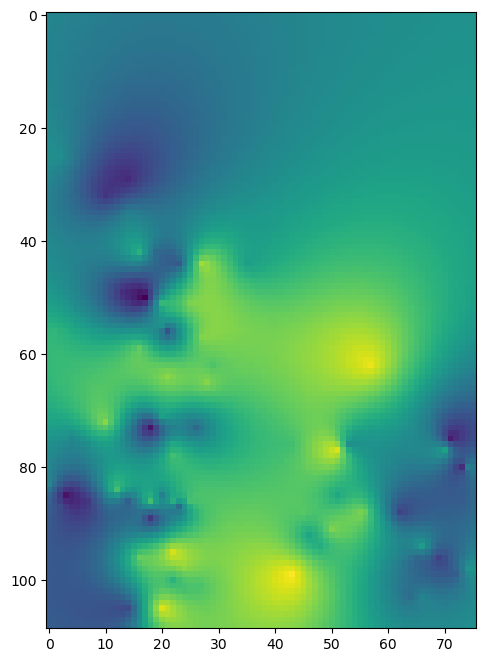

In [4]:
# Let's open up Zach's ICAR+PS predictions:
icar_ps_data = np.load('ps_mu.npy')

# plot icar_ps_data
plt.figure(figsize=(12, 8))
plt.imshow(icar_ps_data, cmap='viridis', aspect='equal')

print("The data is plotted on a 109 x 76 grid, with each grid cell being a half-km square.")


We have the y_trues for the observed data points, but we are obviously missing the y_trues for the unobserved data points. This is where we'll use Zach's ICAR+PS model predictions as "ground truth" values, so we can train our model in a way that minimizes loss. The goal of this is to see if we can recreate the same results as Zach's model.

In [5]:
break

# NB: Zach's ICAR+PS file contains a prediction for each grid cell in the 109x76 grid.

# Let's now set the unobserved grid cells in the gdf to the same values as the ICAR+PS predictions.
# We can do this by indexing into the gdf at the unobserved_grid_cell_indices and setting the 'temp_avg' column to the corresponding values in icar_ps_data.

# Create a copy of the original GeoDataFrame
gdf_new = gdf.copy()

# Iterate over unobserved grid cell indices and update `gdf_new`
num_matches = 0
for row, col in unobserved_grid_cell_indices:
    # Check if any row matches
    matches = gdf_new.loc[(gdf_new['grid_row'] == row) & (gdf_new['grid_col'] == col)]
        
    # Get the prediction value from icar_ps_data for this grid cell
    predicted_value = icar_ps_data[-row, col]

    
    # Update only unobserved cells
    gdf_new.loc[
        (gdf_new['grid_row'] == row) & 
        (gdf_new['grid_col'] == col) & 
        (gdf_new['temp_avg'].isna()), 
        'temp_avg'
    ] = predicted_value

gdf_new.plot(column='temp_avg', cmap='viridis', legend=True, figsize=(12, 8))

# Let's check if that actually did what we want it to do:

# Count non-NaN rows in temp_avg
non_nan_count = gdf_new['temp_avg'].notna().sum()

# Total grid cells = observed + unobserved
expected_count = len(gdf)  # This should match the total number of rows in gdf_new

print(f"Non-NaN count in temp_avg: {non_nan_count}")
print(f"Total grid cells in gdf: {expected_count}")

if non_nan_count == expected_count:
    print("All grid cells have been successfully updated.")
else:
    print("Some grid cells still have NaN values.")



SyntaxError: 'break' outside loop (425791328.py, line 1)

In [ ]:
temp_avg_value = gdf_new.query("grid_row == 0 and grid_col == 0")['temp_avg'].values

# Print the result
if len(temp_avg_value) > 0:
    print(f"The temp_avg value for grid_row=0 and grid_col=0 is: {temp_avg_value[0]}")
else:
    print("No matching row found for grid_row=0 and grid_col=0.")

NameError: name 'gdf_new' is not defined

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
import os

# Assuming the parent directory is one level up from the current script
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

# Now you can import from custom_dk_imports
from custom_dk_imports import DeepKrigingMLP, Trainer

# Define necessary parts from nn.py
class DeepKrigingEmbedding3d(nn.Module):
    def __init__(self, K: int):
        super(DeepKrigingEmbedding3d, self).__init__()
        self.K = K
        self.num_basis = [(9*2**(h-1)+1)**2 for h in range(1,self.K+1)]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, s: torch.Tensor) -> torch.Tensor:
        knots_1d = [torch.linspace(0, 1, int(np.sqrt(i))).to(self.device) for i in self.num_basis]
        N = s.shape[0]
        phi = torch.zeros(N, sum(self.num_basis)).to(self.device)
        K = 0
        for res, num_basis_res in enumerate(self.num_basis):
            theta = 1 / np.sqrt(num_basis_res) * 2.5
            knots_s1, knots_s2 = torch.meshgrid(knots_1d[res], knots_1d[res], indexing='ij')
            knots = torch.stack((knots_s1.flatten(), knots_s2.flatten()), dim=1).to(self.device)
            d = torch.cdist(s, knots) / theta
            mask = (d >= 0) & (d <= 1)
            weights = torch.zeros_like(d)
            weights[mask] = ((1 - d[mask]) ** 6 * (35 * d[mask] ** 2 + 18 * d[mask] + 3) / 3)
            phi[:, K:K + num_basis_res] = weights
            K += num_basis_res
        return phi

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import sys
from custom_dk_imports import DeepKrigingMLP, Trainer, NewLoss


# RECALL: gdf_new is (grid_row, grid_col, temp_avg)

# Extract all coordinates and temp_avg values from gdf_new
grid_points = gdf_new[['x', 'y']].to_numpy()

grid_points = np.vstack(grid_points)
temp_values = gdf_new['temp_avg'].to_numpy()  # Corresponding temperature values

# Convert observed/unobserved grid indices to arrays
observed_grid_cell_indices_array = np.array(list(observed_grid_cell_indices))  # Observed grid indices
unobserved_grid_cell_indices_array = np.array(list(unobserved_grid_cell_indices))  # Unobserved grid indices

# Map (row, col) to flattened indices
observed_flat_indices = np.ravel_multi_index(
    (observed_grid_cell_indices_array[:, 0], observed_grid_cell_indices_array[:, 1]),
    dims=(109, 76)
)
unobserved_flat_indices = np.ravel_multi_index(
    (unobserved_grid_cell_indices_array[:, 0], unobserved_grid_cell_indices_array[:, 1]),
    dims=(109, 76)
)

# Extract observed and unobserved points and values
observed_points = grid_points[observed_flat_indices]
observed_values = temp_values[observed_flat_indices]

print(observed_points)
print(observed_flat_indices[:5])

unobserved_points = grid_points[unobserved_flat_indices]
unobserved_values = temp_values[unobserved_flat_indices]

# Verify the counts
print(f"Number of observed points: {len(observed_points)}")
print(f"Number of unobserved points: {len(unobserved_points)}")
print(f"Total grid cells: {len(grid_points)}")
assert len(observed_points) + len(unobserved_points) == len(grid_points), "Mismatch in total grid cells!"

# Define M as an indicator array for the entire grid
M = np.zeros(len(grid_points))
M[observed_flat_indices] = 1  # Mark observed points


[[ 9.25 26.75]
 [ 4.25  7.75]
 [27.75 30.25]
 [11.75 32.25]
 [34.75 33.25]
 [10.75 15.25]
 [14.75 45.25]
 [22.25 18.75]
 [20.25 36.25]
 [17.75  7.25]
 [29.75  7.25]
 [33.25 43.75]
 [15.25 48.25]
 [21.75 46.25]
 [24.25 36.25]
 [17.75 20.75]
 [ 3.25 48.75]
 [ 2.75 19.25]
 [ 6.75  5.75]
 [35.25 38.25]
 [22.75 42.25]
 [30.25 15.75]
 [26.25 50.75]
 [17.25 38.75]
 [15.25 35.75]
 [15.75 18.75]
 [34.75  0.25]
 [35.75  3.25]
 [12.75 31.75]
 [ 7.75 49.75]
 [24.75 41.75]
 [20.75  3.25]
 [ 8.75 16.75]
 [ 0.75 18.25]
 [21.75 44.75]
 [12.75 32.75]
 [ 1.25 35.25]
 [ 5.25 17.25]
 [13.25 24.75]
 [18.25 40.75]
 [11.25 42.25]
 [33.75 49.75]
 [11.25 46.75]
 [16.75  2.25]
 [31.25 25.25]
 [33.25 43.25]
 [22.75  6.75]
 [13.25 37.25]
 [33.25  5.75]
 [26.25  7.25]
 [13.25 25.75]
 [20.25 11.75]
 [21.25 25.25]
 [17.25 37.25]
 [16.25 40.25]
 [10.25 49.25]
 [ 0.75 39.25]
 [ 6.25 19.25]
 [26.25  8.25]
 [ 3.75 28.75]
 [25.75 29.75]
 [ 0.25 15.75]
 [12.25 48.25]
 [35.25 53.75]
 [ 5.75 41.75]
 [37.75 36.25]
 [17.25 17

s_train mean: [0.50082994 0.49523275], std: [0.29145864 0.29060189]
s_train min: [0. 0.], max: [1. 1.]
y_train mean: 0.004530744087050836, std: 0.9990833855856002
y_train min: -3.1464401051576614, max: 2.597890657701838
phi_train mean: 0.0031308289617300034, std: 0.039927296340465546
phi_train min: 0.0, max: 1.0


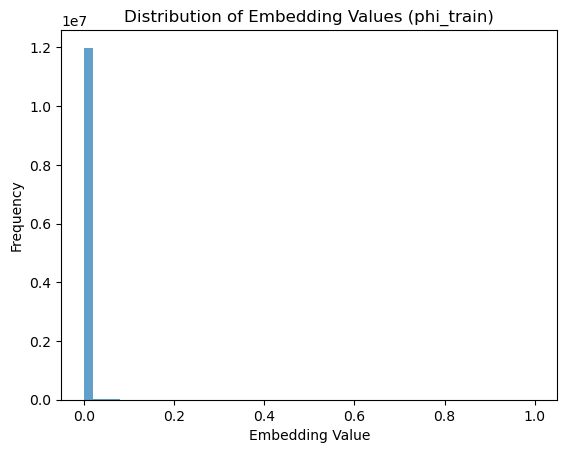

y_train mean: 0.004530743695795536, std: 0.9991587996482849
y_train min: -3.146440029144287, max: 2.597890615463257


In [ ]:
s_train, s_val, y_train, y_val, M_train, M_val = train_test_split(grid_points, temp_values, M, test_size=0.2, random_state=42)
s_test = grid_points  # Use the full grid as the test set

# print(grid_points[:5])
# print(s_train[:5])
# print(y_train[:5])
# print(M_train[:5])

# Convert M_train and M_val back to torch tensors
M_train = torch.tensor(M_train, dtype=torch.float32)
M_val = torch.tensor(M_val, dtype=torch.float32)

# Define model parameters
num_hidden_layers = 1
hidden_dims = 100
K = 3  # embedding layer will update K based on DeepKrigingEmbedding3d

# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding3d(K)
input_dim = sum(embedding_layer.num_basis)  # This should match 1830

# Normalize s-coords
s_min, s_max = grid_points.min(axis=0), grid_points.max(axis=0)
s_train = (s_train - s_min) / (s_max - s_min)
s_val = (s_val - s_min) / (s_max - s_min)
s_test = (s_test - s_min) / (s_max - s_min)

print(f"s_train mean: {s_train.mean(axis=0)}, std: {s_train.std(axis=0)}")
print(f"s_train min: {s_train.min(axis=0)}, max: {s_train.max(axis=0)}")


# Compute the mean and standard deviation of temp_values
y_mean = temp_values.mean()
y_std = temp_values.std()

# Normalize temperature values
y_train = (y_train - y_mean) / y_std
y_val = (y_val - y_mean) / y_std
y_test = (temp_values - y_mean) / y_std

print(f"y_train mean: {y_train.mean()}, std: {y_train.std()}")
print(f"y_train min: {y_train.min()}, max: {y_train.max()}")

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)
s_all_tensor = torch.tensor(grid_points, dtype=torch.float32)
# print(s_train_tensor)

embedding_layer.eval()
# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)
phi_all = embedding_layer(s_all_tensor)

print(f"phi_train mean: {phi_train.mean().item()}, std: {phi_train.std().item()}")
print(f"phi_train min: {phi_train.min().item()}, max: {phi_train.max().item()}")

import matplotlib.pyplot as plt

phi_train_np = phi_train.detach().cpu().numpy().flatten()
plt.hist(phi_train_np, bins=50, alpha=0.7)
plt.title("Distribution of Embedding Values (phi_train)")
plt.xlabel("Embedding Value")
plt.ylabel("Frequency")
plt.show()



# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)
y_all_tensor = torch.tensor(temp_values, dtype=torch.float32).view(-1, 1)

print(f"y_train mean: {y_train.mean().item()}, std: {y_train.std().item()}")
print(f"y_train min: {y_train.min().item()}, max: {y_train.max().item()}")



deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='relu')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

Training started:

Epoch 1/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.9521
Validation:
0s - loss 0.7699

Epoch 2/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.8014
Validation:
0s - loss 0.7654

Epoch 3/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7953
Validation:
0s - loss 0.7677

Epoch 4/100
Learning rate: 0.001000
1s for 208 steps - 3ms/step - loss 0.7920
Validation:
0s - loss 0.7669

Epoch 5/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7910
Validation:
0s - loss 0.7650

Epoch 6/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7894
Validation:
0s - loss 0.7662

Epoch 7/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7901
Validation:
0s - loss 0.7669

Epoch 8/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7862
Validation:
0s - loss 0.7658

Epoch 9/100
Learning rate: 0.001000
0s for 208 steps - 2ms/step - loss 0.7891
Validation:
0s - loss 0.7644

Epoch 10/

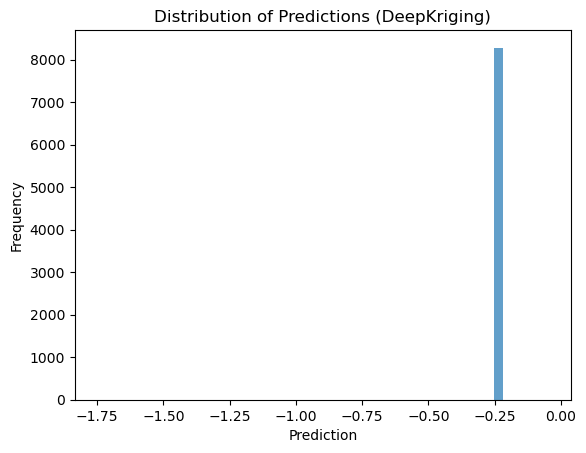

In [ ]:
from custom_dk_imports import NewLoss
trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 0.001},
    loss_fn=NewLoss(s_all=grid_points, observed_indices=observed_flat_indices, y_all=temp_values),
    # loss_fn=nn.MSELoss(),
    M_train=M_train,
    M_val=M_val,
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_all).cpu().numpy()

print(f"y_pred_deepkriging shape: {y_pred_deepkriging.shape}")
print(f"First few predictions: {y_pred_deepkriging[:5]}")

plt.hist(y_pred_deepkriging, bins=50, alpha=0.7)
plt.title("Distribution of Predictions (DeepKriging)")
plt.xlabel("Prediction")
plt.ylabel("Frequency")
plt.show()


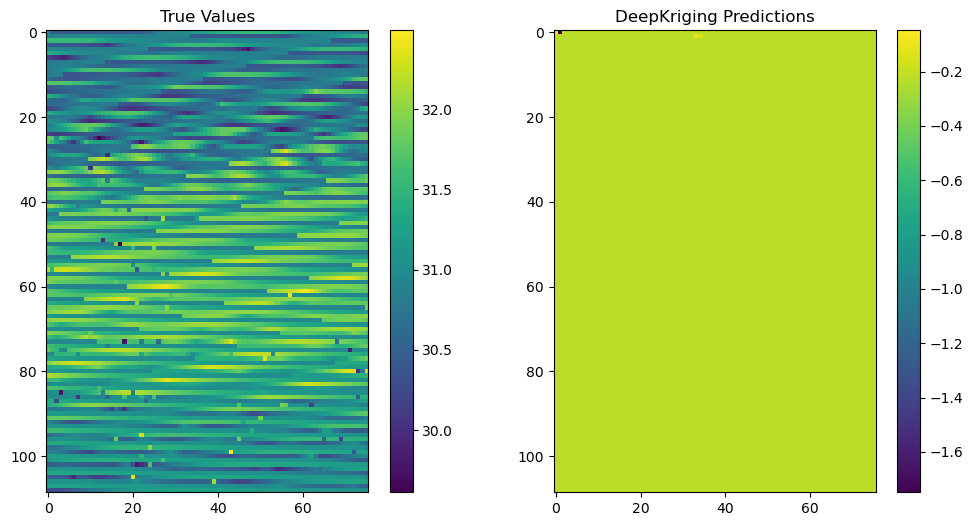

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(temp_values.reshape(109, 76), cmap='viridis')
plt.title('True Values')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(y_pred_deepkriging.reshape(109, 76), cmap='viridis')
plt.title('DeepKriging Predictions')
plt.colorbar()

plt.show()


In [ ]:
noise_var = 0.01  # Nugget variance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

kernel = 1 * Matern(length_scale=0.1, nu=1.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

gp.fit(s_train[M_train.numpy().astype(bool)], y_train[M_train.numpy().astype(bool)])   
y_pred_gp, y_std_gp = gp.predict(grid_points, return_std=True)

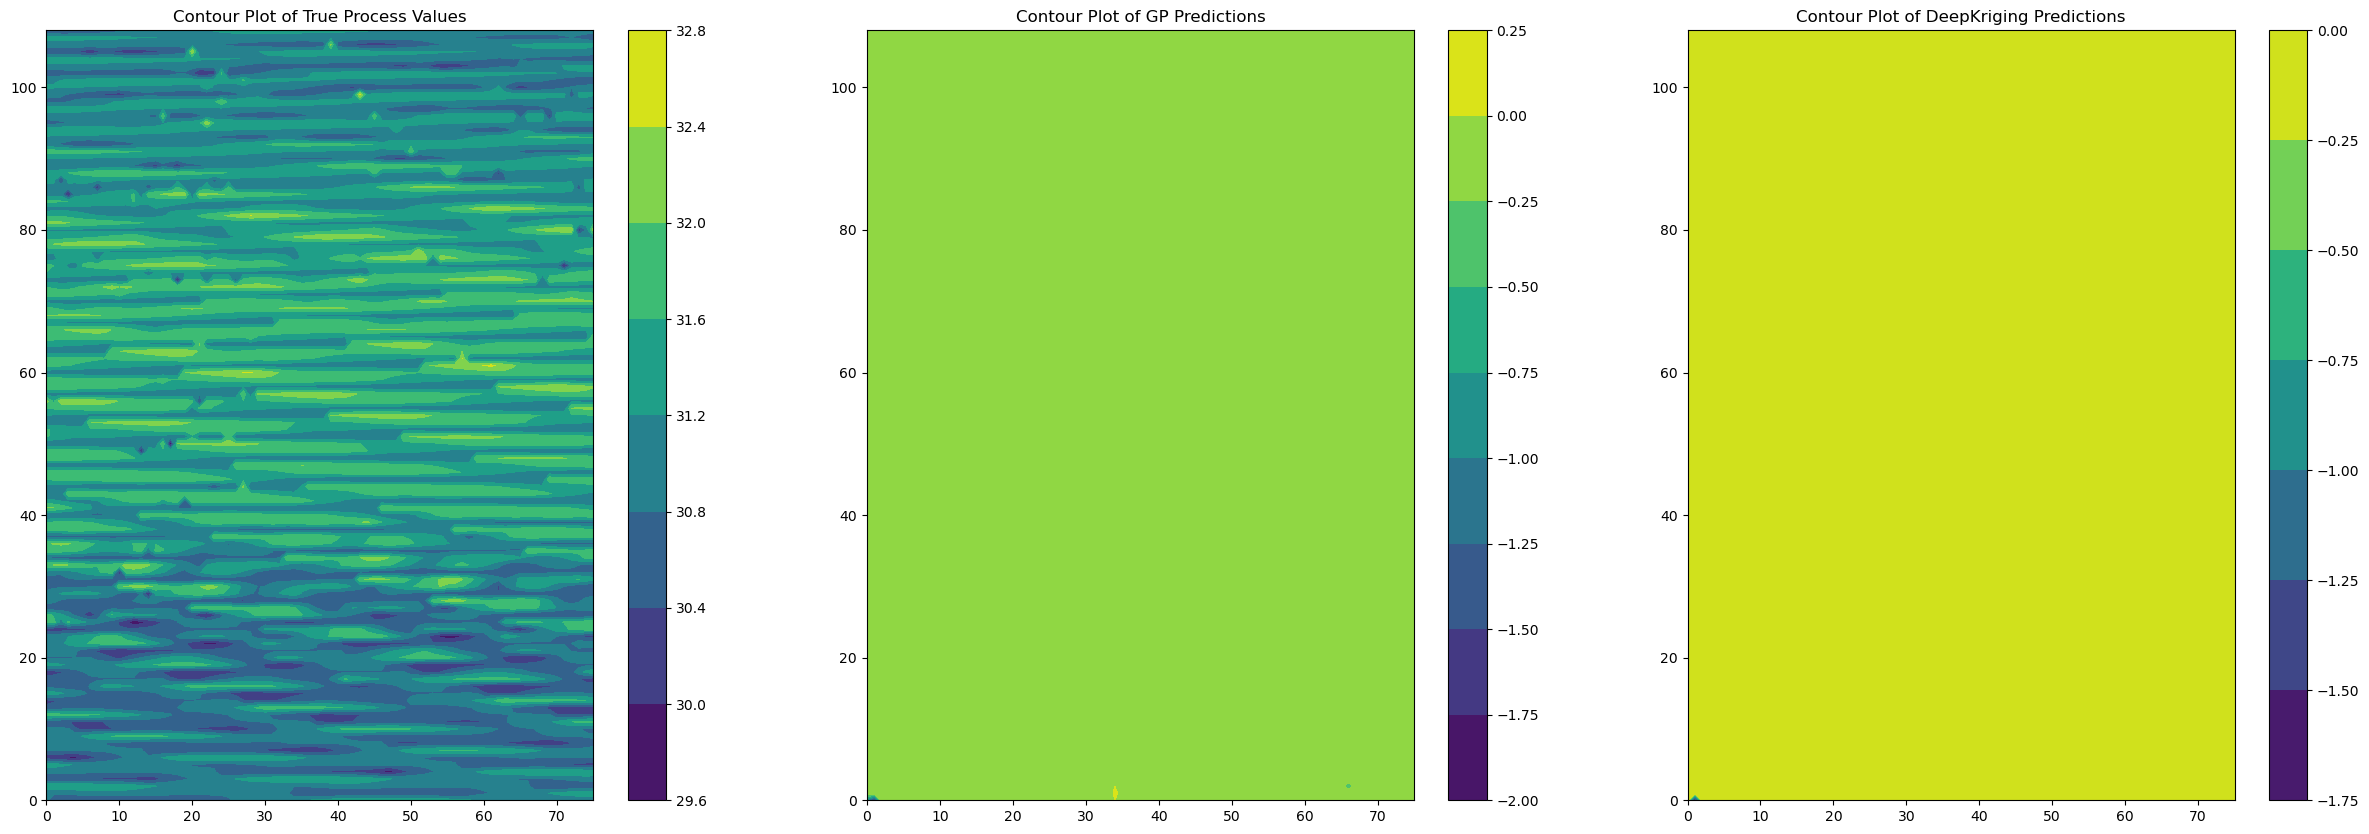

In [ ]:
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(30, 10))
gs = gridspec.GridSpec(1, 3)
ax = plt.subplot(gs[0, 0])

X = np.arange(0, 76, 1)
Y = np.arange(0, 109, 1)
process_values_grid = temp_values.reshape(109, 76)

contour1 = ax.contourf(X, Y, process_values_grid, cmap='viridis')
cbar1 = plt.colorbar(contour1, ax=ax)
ax.set_title("Contour Plot of True Process Values")

ax = plt.subplot(gs[0, 1])
# # Plot DeepKriging predictions directly on the test points
contour2 = ax.contourf(X, Y, y_pred_gp.reshape(109, 76), cmap='viridis')
cbar2 = plt.colorbar(contour2, ax=ax)
ax.set_title("Contour Plot of GP Predictions")

ax = plt.subplot(gs[0, 2])
# # Plot GP predictions directly on the test points
contour3 = ax.contourf(X, Y, y_pred_deepkriging.reshape(109, 76), cmap='viridis')
cbar3 = plt.colorbar(contour3, ax=ax)
ax.set_title("Contour Plot of DeepKriging Predictions")



plt.show()